#### This code models the collective motions of the IR as response to the motion of the TMD

In [1]:
# imports
import numpy as np
import typing
import sklearn as sk
import pylab as plt
import seaborn as sns
import matplotlib as mpl
import warnings
import matplotlib.ticker as mtick
#from numpy import linalg as la
import pandas as pd
import pathlib
#from typing import Tuple, Any, Union
from os.path import exists
#from sklearn.cross_decomposition import PLSRegression
import scipy as scp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# install https://github.com/molecularmachinist/OPLS-MD
from OPLS_MD import OPLS, OPLS_PLS, PLS

In [2]:
# settings
warnings.filterwarnings('ignore')
sns.set_context("talk")

sns.set(font_scale = 2)
sns.set_style('white')

In [3]:
# constants
stride = 1
colors = ['r','b','g','orange','cyan','indigo','purple','magenta','brown','k']
n_traj = 4
start = 0

In [4]:
# code

In [5]:
# read and generate data

data_path = '/wrk/romiromi/work/free_simu_analysis/without_fibro/salt_bridge_analysis_1.5us_simu/PLS/data/'
#data_path = '/wrk/romiromi/work/free_simu_analysis/without_fibro/salt_bridge_analysis_1.5us_simu/PLS/shorter_sb_data/'

In [6]:
dist1 = np.load(data_path +f"distance_map_1.npy")
dist2 = np.load(data_path +f"distance_map_2.npy")
dist3 = np.load(data_path +f"distance_map_3.npy")
dist4 = np.load(data_path +f"distance_map_4.npy")

dist_maps = np.concatenate((dist1, dist2), axis=0)
dist_maps = np.concatenate((dist_maps, dist3), axis=0)
dist_maps = np.concatenate((dist_maps, dist4), axis=0)

In [7]:
print(dist_maps.shape)

(60004, 159)


In [8]:

bond_names = np.load(data_path + "common_contact_map_names.npy")

In [9]:
dist1_all = np.load(data_path +f"distance_map_1_all.npy")
dist2_all = np.load(data_path +f"distance_map_2_all.npy")
dist3_all = np.load(data_path +f"distance_map_3_all.npy")
dist4_all = np.load(data_path +f"distance_map_4_all.npy")

dist_maps_all = np.concatenate((dist1_all, dist2_all), axis=1)
dist_maps_all = np.concatenate((dist_maps_all, dist3_all), axis=1)
dist_maps_all = np.concatenate((dist_maps_all, dist4_all), axis=1)

all_bond_names = np.load(data_path + "common_contact_map_names_all.npy")


In [10]:
dist_maps_all = dist_maps_all.T
print(dist_maps_all.shape)

(60004, 11132)


In [11]:
proj1 = np.load(data_path +"projection_traj_1.npy")
proj2 = np.load(data_path +"projection_traj_2.npy")
proj3 = np.load(data_path +"projection_traj_3.npy")
proj4 = np.load(data_path +"projection_traj_4.npy")

projs = np.concatenate((proj1, proj2), axis=0)
projs = np.concatenate((projs, proj3), axis=0)
projs = np.concatenate((projs, proj4), axis=0)
print(projs.shape)

(60004,)


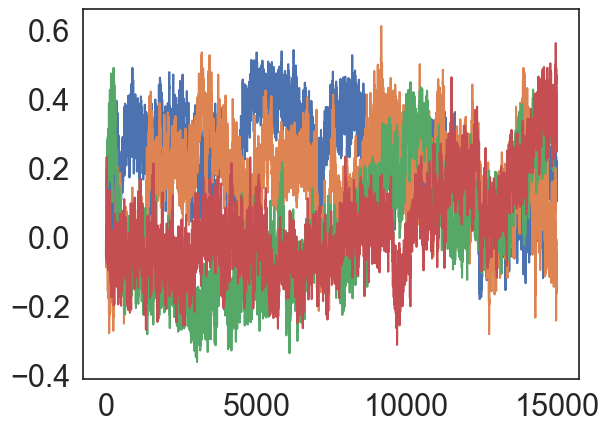

In [12]:
plt.plot(proj1)
plt.plot(proj2)
plt.plot(proj3)
plt.plot(proj4)

In [13]:
# Optimize the n_components

train_split = 0.5
data = {}
maxcomp = 5
stride = 1
label = "ionic_bonds"


data[label] = {}
data[label]["ncomp"] = []
data[label]["test_scores"] = []
data[label]["train_scores"] = []
data[label]["test_scores_opls"] = []
data[label]["train_scores_opls"] = []

# Test and train sets
X_train, X_test, \
y_train, y_test = train_test_split(
                    dist_maps, projs,
                    test_size=train_split,
                    random_state=42
                )

#print(f"X_train = shape{X_train.shape}\nX_test  = shape{X_test.shape}")
#print(f"y_train = shape{y_train.shape}\ny_test  = shape{y_test.shape}")

print(f"Now running PLS...")

# call pls
# iterate over different number of components
for ncomp in range(1,maxcomp+1):
    print(f"Building models with {ncomp} components", end="\r")
    pls      = PLS(n_components=ncomp).fit(X_train, y_train)
    opls = OPLS_PLS(pls_components=ncomp).fit(X_train, y_train)

    data[label]["ncomp"].append(ncomp)
    data[label]["test_scores"].append(pls.score(X_test, y_test))
    data[label]["train_scores"].append(pls.score(X_train, y_train))
    data[label]["test_scores_opls"].append(opls.score(X_test, y_test))
    data[label]["train_scores_opls"].append(opls.score(X_train, y_train))
    
    print(f"Train score: {data[label]['train_scores_opls'][ncomp-1]}")
    print(f"Test score: {data[label]['test_scores_opls'][ncomp-1]}")


print(f"Done! Built models up to {maxcomp} components.")

Now running PLS...
Train score: 0.5643837984544449ts
Test score: 0.5698876360711742
Train score: 0.5856426034908896ts
Test score: 0.5896563525878745
Train score: 0.6052181212679104ts
Test score: 0.6082554511376032
Train score: 0.6144132228189378ts
Test score: 0.6166518453108489
Train score: 0.6212356549816116ts
Test score: 0.6231508632813616
Done! Built models up to 5 components.


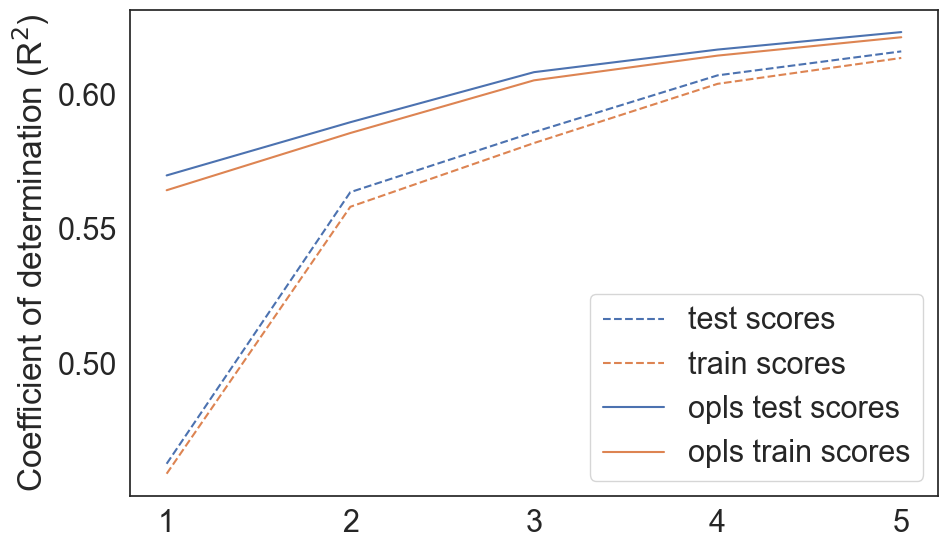

In [14]:
# Plot scores over numbers of components
fig,ax = plt.subplots(1)

key = 'ionic_bonds'
    
ax.plot(data[key]["ncomp"], data[key]["test_scores"],  "--", c="C0", label="test scores")
ax.plot(data[key]["ncomp"], data[key]["train_scores"], "--", c="C1", label="train scores")
ax.plot(data[key]["ncomp"], data[key]["test_scores_opls"],   c="C0", label="opls test scores")
ax.plot(data[key]["ncomp"], data[key]["train_scores_opls"],  c="C1", label="opls train scores")

ax.legend()
ax.set_ylabel("Coefficient of determination (R$^2$)")

fig.set_size_inches(10,6)
fig.tight_layout()

In [15]:
# Optimize the n_components

train_split = 0.5
data = {}
maxcomp = 5
stride = 10
label = "ionic_bonds"


data[label] = {}
data[label]["ncomp"] = []
data[label]["test_scores"] = []
data[label]["train_scores"] = []
data[label]["test_scores_opls"] = []
data[label]["train_scores_opls"] = []

# Test and train sets
X_train, X_test, \
y_train, y_test = train_test_split(
                    dist_maps_all, projs,
                    test_size=train_split,
                    random_state=42
                )

#print(f"X_train = shape{X_train.shape}\nX_test  = shape{X_test.shape}")
#print(f"y_train = shape{y_train.shape}\ny_test  = shape{y_test.shape}")

print(f"Now running PLS...")

# call pls
# iterate over different number of components
for ncomp in range(1,maxcomp+1):
    print(f"Building models with {ncomp} components", end="\r")
    pls      = PLS(n_components=ncomp).fit(X_train, y_train)
    opls = OPLS_PLS(pls_components=ncomp).fit(X_train, y_train)

    data[label]["ncomp"].append(ncomp)
    data[label]["test_scores"].append(pls.score(X_test, y_test))
    data[label]["train_scores"].append(pls.score(X_train, y_train))
    data[label]["test_scores_opls"].append(opls.score(X_test, y_test))
    data[label]["train_scores_opls"].append(opls.score(X_train, y_train))
    
    print(f"Train score: {data[label]['train_scores_opls'][ncomp-1]}")
    print(f"Test score: {data[label]['test_scores_opls'][ncomp-1]}")


print(f"Done! Built models up to {maxcomp} components.")

Now running PLS...
Train score: 0.9706801722136642ts
Test score: 0.9709246337988792
Train score: 0.9829554959161363ts
Test score: 0.9833709497943794
Train score: 0.9901591920078571ts
Test score: 0.9903268914782991
Train score: 0.9933724977990448ts
Test score: 0.993294836574405
Train score: 0.9959754674997577ts
Test score: 0.9958881155181569
Done! Built models up to 5 components.


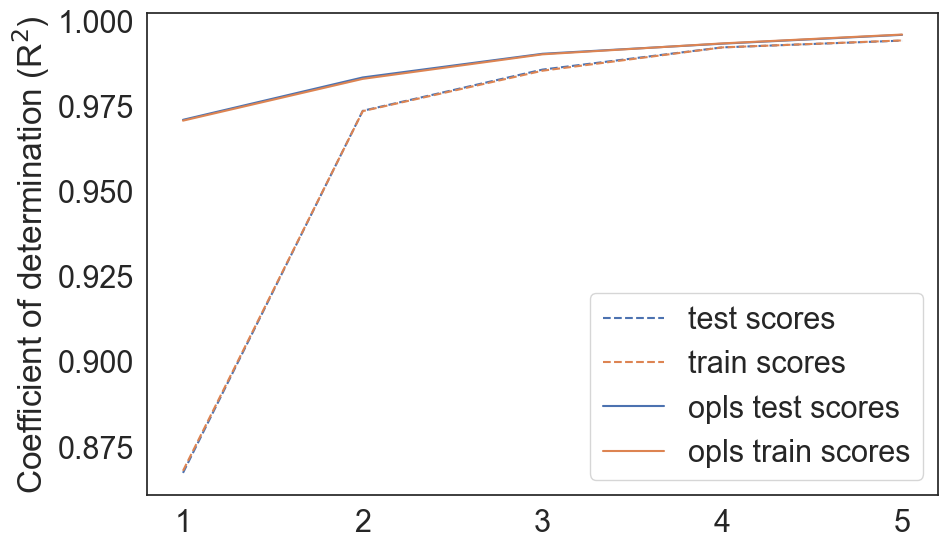

In [16]:
# Plot scores over numbers of components
fig,ax = plt.subplots(1)

key = 'ionic_bonds'
    
ax.plot(data[key]["ncomp"], data[key]["test_scores"],  "--", c="C0", label="test scores")
ax.plot(data[key]["ncomp"], data[key]["train_scores"], "--", c="C1", label="train scores")
ax.plot(data[key]["ncomp"], data[key]["test_scores_opls"],   c="C0", label="opls test scores")
ax.plot(data[key]["ncomp"], data[key]["train_scores_opls"],  c="C1", label="opls train scores")

ax.legend()
ax.set_ylabel("Coefficient of determination (R$^2$)")

fig.set_size_inches(10,6)
fig.tight_layout()

In [17]:
# functions

def plot_residue_importance(X, y, bond_list,  N=10, title = "", ncomp=2):

    # number of components
    #ncomp  = 5

    # Normalize the data
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    y_reshaped = np.reshape(y, (-1, 1))
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y_reshaped)

    # Build the PLS model
    opls = OPLS_PLS(pls_components=ncomp).fit(X, y)
    # Get the PLS components
    X_pls = opls.transform(X)
    # Get the coefficients
    coefficients = opls.pls_.coef_
    coefficients = coefficients.flatten()
    print(len(coefficients))
    sorted_coeffs = sorted(coefficients,reverse=True)


    # Sort bonds by importance

    sorted_pairs = sorted(zip(bond_list, coefficients), reverse=True)
    sorted_bonds =  [item for item, _  in sorted_pairs]


    # Get the first N residues
    top_bonds = sorted_bonds[:N]
    top_coeff = sorted_coeffs[:N]
    print(top_bonds)

    # Create the waterfall plot
    #plt.bar(range(N), [val for  val in top_coeff])
    #plt.xticks(range(N),[f"{bond}"  for bond in top_bonds], rotation = 'vertical',  fontsize=8)
    #plt.xlabel('Residue')
    #plt.ylabel('Importance')
    #plt.title(f'Top {N} Important Residues {title}')
    #plt.tight_layout()
    #plt.show()

    # Create the waterfall plot
    plt.barh(range(N), [val for val in top_coeff])
    plt.yticks(range(N), [f"{bond}" for bond in top_bonds], fontsize=8)
    plt.ylabel('Residue')
    plt.xlabel('Importance')
    plt.title(f'Top {N} Important Residues {title}')
    plt.tight_layout()  # Adjusts plot to fit elements properly
    plt.show()


11132
['LYS9_GLU94', 'LYS9_GLU91', 'LYS9_GLU90', 'LYS9_GLU89', 'LYS9_GLU88', 'LYS9_GLU84', 'LYS9_GLU81', 'LYS9_GLU71', 'LYS9_GLU61', 'LYS9_GLU6']


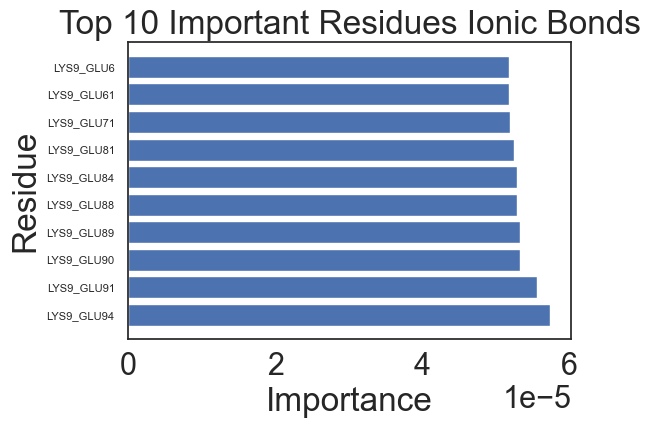

In [18]:

plot_residue_importance(X = dist_maps_all, y = projs, bond_list=all_bond_names, N = 10, title = "Ionic Bonds", ncomp=2)

159
['LYS96_GLU94', 'LYS96_ASP73', 'LYS87_GLU89', 'LYS87_GLU84', 'LYS87_GLU119', 'LYS87_ASP90', 'LYS87_ASP120', 'LYS85_GLU84', 'LYS85_GLU119', 'LYS85_ASP159', 'LYS85_ASP120', 'LYS80_GLU84', 'LYS80_GLU119', 'LYS80_ASP120', 'LYS75_GLU94', 'LYS75_GLU147', 'LYS75_ASP73', 'LYS73_GLU89', 'LYS73_GLU432', 'LYS71_GLU89']


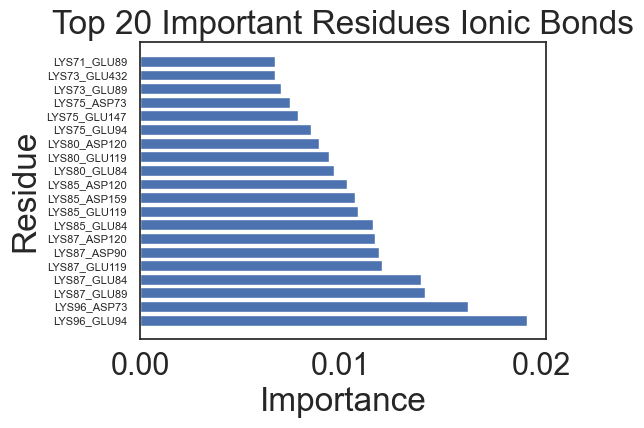

In [19]:
plot_residue_importance(X = dist_maps, y = projs, bond_list=bond_names, N = 20, title = "Ionic Bonds", ncomp=5)